In [ ]:
"""
from scipy.spatial.distance import cdist #Required >1.8.1
from scipy.stats import pearsonr

from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import RootMeanSquaredError
"""

In [1]:
import utils_ml
import utils
from utils_ml import *
import pandas as pd
import numpy as np
import warnings
import os
from tqdm import tqdm
import logging
from functools import reduce
from typing import List, Dict, Tuple, Any, Union

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from keras import callbacks
from keras.regularizers import L2

In [42]:
from scipy.stats import theilslopes
from scipy.spatial.distance import cdist
import pandas as pd
import utils


def get_dummy_variables(index:pd.DatetimeIndex) -> pd.DataFrame:
    """
    Create dummy variables for month and year
    """
    dumbies_df = pd.get_dummies(index.month_name())
    dumbies_df = dumbies_df.set_index(index)
    dumbies_df = dumbies_df.astype(int)
    return dumbies_df
    

def generate_priors(
    y_data: pd.Series, 
    indecies: well_indecies, 
    regression_percentages: list = [0.10, 0.15, 0.25, 0.5, 1.0],
    regression_intercept_percentage: float = 0.10,
    windows: list = [18, 24, 36, 60], 
    ) -> pd.DataFrame:
    center = interpolate_center(series = y_data.dropna(), imputation_index = indecies.interpolation_index)
    left = extrapolate_left(
        series = y_data, 
        imputation_index = indecies.imputation_range, 
        regression_percentages = regression_percentages, 
        regression_intercept_percentage = regression_intercept_percentage)
    right = extrapolate_right(
        series = y_data, 
        imputation_index = indecies.imputation_range, 
        regression_percentages = regression_percentages, 
        regression_intercept_percentage = regression_intercept_percentage)
    prior = merge_series(series_list = [left, right, center])
    prior_features = extract_priors(prior, windows)
    return prior, prior_features


def interpolate_center(series:pd.Series, imputation_index:pd.DatetimeIndex) -> pd.Series:
    center = utils.interpolate_pchip(series, imputation_index)
    return center

def extrapolate_left(
    series:pd.Series, 
    imputation_index:pd.DatetimeIndex,
    regression_percentages:list = [0.10, 0.15, 0.25, 0.5, 1.0],
    regression_intercept_percentage:float = 0.10,
    ) -> pd.Series:
    # check if there are measurements before the imputation index
    # if there are, we don't need to extrapolate the values will be derived using pchip
    series_index = series.dropna().index
    series_start = series_index[0]
    imputation_start = imputation_index[0]
    if check_date_greater_than(series_start, imputation_start):
        slopes = []
        for percentage in regression_percentages:
            series_subset_mask = generate_percentage_idecies(series_index, percentage)
            slope, _, _, _ = interpolate_theil_slope(series.loc[series_subset_mask])
            slopes.append(slope)
        slope = np.mean(slopes)
        mask = utils.make_dataframe_mask(imputation_index, start_date = imputation_start, end_date = series_start)
        extrapolation_index = series.index[mask]
        intercept = np.mean(series.loc[generate_percentage_idecies(series.index, regression_intercept_percentage)])
        series_extrapolation = pd.Series(index = extrapolation_index)
        series_extrapolation = linear_extrapolate(series_extrapolation, slope, intercept)
        series_extrapolation = reverse_series(series_extrapolation)
    else:
        series_extrapolation = None
    return series_extrapolation


def extrapolate_right(
    series:pd.Series, 
    imputation_index:pd.DatetimeIndex,
    regression_percentages:list = [0.10, 0.15, 0.25, 0.5, 1.0],
    regression_intercept_percentage:float = 0.10,
    ) -> pd.Series:
    # check if there are measurements after the imputation index
    # if there are, we don't need to extrapolate the values will be derived using pchip
    series_index = series.dropna().index
    series_end = series_index[-1]
    imputation_end = imputation_index[-1]
    if check_date_greater_than(imputation_end, series_end):
        slopes = []
        for percentage in regression_percentages:
            series_subset_mask = generate_percentage_idecies(series_index, percentage)
            slope, _, _, _ = interpolate_theil_slope(series.loc[series_subset_mask])
            slopes.append(slope)
        slope = np.mean(slopes)
        mask = utils.make_dataframe_mask(imputation_index, start_date = series_end, end_date = imputation_end)
        extrapolation_index = series.index[mask]
        series = reverse_series(series)
        intercept = np.mean(series.loc[generate_percentage_idecies(series.index, regression_intercept_percentage)])
        series = pd.Series(index = extrapolation_index)
        
        series = reverse_series(series)
        series_extrapolation = linear_extrapolate(series, slope, intercept)
    else:
        series_extrapolation = None
    return series_extrapolation


def reverse_series(series:pd.Series) -> pd.Series:
    return series[::-1]

def check_date_greater_than(datetime_index1:pd.DatetimeIndex, datetime_index2:pd.DatetimeIndex) -> bool:
    return datetime_index1 > datetime_index2


def interpolate_theil_slope(
    series: pd.Series,
) -> float:
        slope, intercept, low_slope, high_slope = theilslopes(series.values, series.index.to_julian_date(), 0.95)
        return slope, intercept, low_slope, high_slope


def generate_percentage_idecies(index:pd.DatetimeIndex, percentage:float) -> pd.DatetimeIndex:
    return index[:int(len(index)*percentage)]


def linear_extrapolate(
    series:pd.Series,
    slope:float,
    intercept:float,
    ) -> pd.Series:
    extrapolation_index_int = series.index.to_julian_date()
    extrapolation = slope * (extrapolation_index_int - extrapolation_index_int[0]) + intercept
    extrapolation = pd.Series(extrapolation, index = series.index)
    return extrapolation


def merge_series(series_list:list) -> pd.Series:
    series_list = [series for series in series_list if series is not None]
    series = pd.concat(series_list, axis = 0, join = 'outer')
    return series.sort_index()


def concat_dataframes(df1:pd.DataFrame, df2:pd.DataFrame, method:str = 'outer', axis:int = 1):
    return pd.concat([df1, df2], join = method, axis=1)


def extract_priors(series:pd.Series, windows:list) -> pd.DataFrame:
    rw_dict = dict()
    for _, window in enumerate(windows):
        key = str(window) + 'm_rw'
        rw = series.rolling(window, center=True, min_periods = 1).mean()
        rw_dict[key] = rw
    rw = pd.DataFrame.from_dict(rw_dict)
    return rw


def get_nearest_data_index(
    query:pd.DataFrame,
    source:pd.DataFrame,
    k:int = 1,
    ) -> list:
    query = query.apply(pd.to_numeric, errors='coerce').astype(float)
    source = source.apply(pd.to_numeric, errors='coerce').astype(float)
    dist = pd.DataFrame(cdist(query, source, metric='euclidean'), columns=source.index).T
    dist = dist.sort_values(by=0)
    nearest_data = source.loc[dist.index[:k]]
    return nearest_data.index.tolist()


def get_data_from_dataframe(
    cells: list,
    data_df: pd.DataFrame,
    ) -> pd.DataFrame:
    return data_df.loc[cells]


def remote_sensing_data_selection(
    data_dict:dict,
    location_key:str,
    location_query: pd.DataFrame,
    k=1,
    ) -> pd.DataFrame:
    cell_names = get_nearest_data_index(location_query, data_dict[location_key], k = k)
    data = data_dict[cell_names[0]]
    return data


def dataframe_split(
    dataframe:pd.DataFrame,
    split_column:str,
    ) -> Union[pd.DataFrame, pd.DataFrame]:

    y = dataframe[split_column].to_frame()
    x = dataframe.drop(columns = split_column)
    return y, x


def dataframe_join(
    df1: pd.DataFrame, 
    df2: pd.DataFrame, 
    method: str = 'outer', 
    axis: int = 1
    ) -> pd.DataFrame:
    return pd.concat([df1, df2], join = method, axis=1)


def scaler_pipline(
    x: pd.DataFrame, 
    scaler_object: object, 
    features_to_pass: List[str],
    train: bool = False,
    ) -> Union[pd.DataFrame, object]:
    if train == True:
        x_scale = x.drop(features_to_pass, axis=1)
        x_partial = scaler_object.fit_transform(x_scale)
        x_partial = pd.DataFrame(x_partial, index = x_scale.index, columns = x_scale.columns)
        x = dataframe_join(x_partial, x[features_to_pass], method='inner')
        return [x, scaler_object]
        
    else:
        x_scale = x.drop(features_to_pass, axis=1)
        x_temp = scaler_object.transform(x_scale)
        x_temp = pd.DataFrame(x_temp, index = x_scale.index, columns = x_scale.columns)
        x = dataframe_join(x_temp, x[features_to_pass], method='inner')
        return x

In [8]:
import utils_ml
import utils

# set project arguments
project_args = utils.ProjectSettings(
    aquifer_name = 'Beryl-Enterprise, Utah', 
    figure_dir = 'Figures Imputed/',
    iteration = 1
    )

# create metrics class
metrics_class = utils_ml.Metrics()

# Configure logging
logging.basicConfig(filename=os.path.join(project_args.data_dir,'error.log'), level=logging.ERROR)

In [63]:
# Load preprocessed data
data_dict_pdsi =  utils.load_pickle(file_name = "PDSI_Data.pickle", path = project_args.data_dir)
data_dict_gldas =  utils.load_pickle(file_name = "GLDAS_Data.pickle", path = project_args.data_dir)
data_dict_well = utils.load_pickle(file_name = "BerylEnterpriseData.pickle", path = project_args.data_dir)
data_dict_well["runs"] = {}

In [11]:
# load sample pdsi data
data_dict_pdsi['Cell_2346']

,sc_PDSI_pm_filled
1871-01-01,6.979250
1871-02-01,6.389672
1871-03-01,5.481109
1871-04-01,4.792531
1871-05-01,4.150930
...,...
2020-08-01,-1.036311
2020-09-01,-1.652903
2020-10-01,-2.011210
2020-11-01,-1.962558


In [12]:
# create list of well ids and imputation range for dataframe creation
imputation_range = utils.make_interpolation_index()
well_ids = list(map(str, data_dict_well["timeseries"].columns))

In [65]:
# create summary metrics dataframe and imputation dataframe
summary_metrics_df = pd.DataFrame(index = well_ids, columns = metrics_class.metrics)
imputation_df = pd.DataFrame(index = imputation_range, columns = well_ids)
model_output_df = pd.DataFrame(index = imputation_range, columns = well_ids)

In [14]:
# get a single cell for testing
well_id = well_ids[0]

In [15]:
# set up well parameters to load correct data
well_class = utils_ml.well_indecies(
    well_id = well_id, 
    series = data_dict_well["timeseries"][well_id], 
    location = pd.DataFrame(data_dict_well['locations'].loc[well_id]).T,
    imputation_range = imputation_range)
y_raw = well_class.raw_series
y_data = well_class.data


In [16]:
# create dummy variables
table_dumbies = get_dummy_variables(y_data.index)
table_dumbies

,April,August,December,February,January,July,June,March,May,November,October,September
1948-01-01,0,0,0,0,1,0,0,0,0,0,0,0
1948-02-01,0,0,0,1,0,0,0,0,0,0,0,0
1948-03-01,0,0,0,0,0,0,0,1,0,0,0,0
1948-04-01,1,0,0,0,0,0,0,0,0,0,0,0
1948-05-01,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,0,0,0,0,0,0,0,0,0,0,0,1
2019-10-01,0,0,0,0,0,0,0,0,0,0,1,0
2019-11-01,0,0,0,0,0,0,0,0,0,1,0,0
2019-12-01,0,0,1,0,0,0,0,0,0,0,0,0


373338113431502


<Axes: >

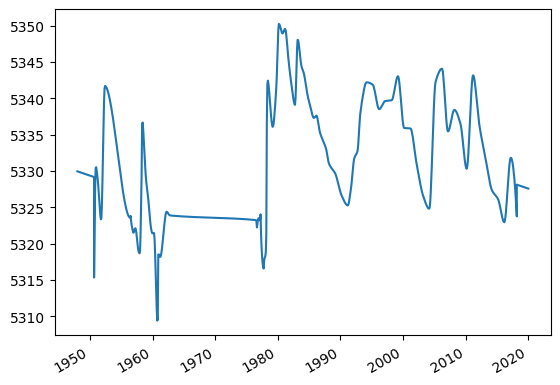

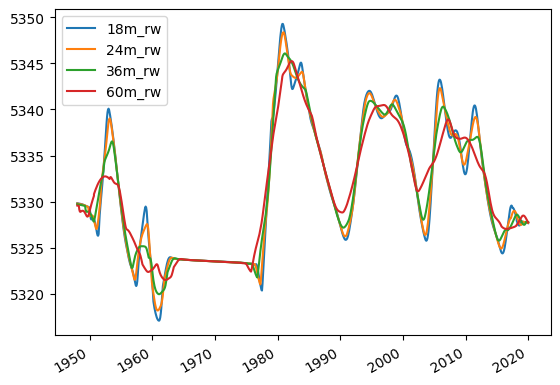

In [17]:
# create prior features based on well trends
prior, prior_features = generate_priors(
    y_data = y_data, 
    indecies=well_class,
    )

print(well_id)
prior.plot()
prior_features.plot()

In [18]:
# pdsi data cell selection
table_pdsi = remote_sensing_data_selection(data_dict_pdsi, 'Location', well_class.location)

# gldas data cell selection
table_gldas = remote_sensing_data_selection(data_dict_gldas, 'Location', well_class.location)

In [19]:
# subset GLDAS data
table_gldas = table_gldas[[
    'Psurf_f_inst', 
    'Wind_f_inst', 
    'Qair_f_inst', 
    'Qh_tavg', 
    'Qsb_acc', 
    'PotEvap_tavg', 
    'Tair_f_inst', 
    'Rainf_tavg',
    'SoilMoi0_10cm_inst',
    'SoilMoi10_40cm_inst',
    'SoilMoi40_100cm_inst',
    'SoilMoi100_200cm_inst',
    'CanopInt_inst',
    'SWE_inst',
    'Lwnet_tavg',
    'Swnet_tavg',
    ]]


In [20]:
# calculate surface water feature from GLDAS
sw_names = [
    "SoilMoi0_10cm_inst",
    "SoilMoi10_40cm_inst",
    "SoilMoi40_100cm_inst",
    "SoilMoi100_200cm_inst",
    "CanopInt_inst",
    "SWE_inst",
]
table_sw = pd.DataFrame(table_gldas[sw_names].sum(axis=1).rename("Surface Water"))

In [27]:
# generate additional groundwater features
gw_names = ['Qsb_acc', 'SWE_inst', 'Rainf_tavg']
table_gwf = table_gldas[gw_names].assign(
    **{
        'ln(QSB_acc)': np.log(table_gldas['Qsb_acc']),
        'ln(RW 4 Rainf_tavg)': np.log(table_gldas['Rainf_tavg'].rolling(4, min_periods=1).sum()),
        'Sum Soil Moist': (table_sw.squeeze() - table_gldas['CanopInt_inst'] - table_gldas['SWE_inst']).rolling(3, min_periods=1).sum()
    }
).drop(columns=gw_names)

In [28]:
# collect feature dataframes into list: pdsi, gldas, prior features, sw, gwf, and dummies
tables_merge = [
    table_pdsi,
    table_gldas,
    prior_features,
    table_sw,
    table_gwf,
    table_dumbies,
]

# iteratively merge predictors dataframes and drop rows with missing values
merged_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="left"), tables_merge).dropna()

In [47]:
# merge features with labels
well_set = y_data.to_frame(name= well_id).join(merged_df, how='outer')

# match timeseries index by droping missing rows not in the label set
well_set_clean = well_set.dropna()

# split dataframe into features and labels
y, x = dataframe_split(well_set_clean, well_id)

In [48]:
# specify features that will be scaled with StandardScaler
features_to_scale = prior_features.columns.to_list() + table_sw.columns.to_list() + table_gwf.columns.to_list()

# specify features that will be passed through without scaling
features_to_pass = table_dumbies.columns.to_list()

# create scaler object
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

In [53]:
# Create folds to split data into train, validation, and test sets
n_epochs = []
n_folds = 5
current_fold = 1

(y_kfold, x_kfold) = (y.to_numpy(), x.to_numpy())
kfold = KFold(n_splits = n_folds, shuffle = False)
temp_metrics = pd.DataFrame(columns = metrics_class.metrics)
model_runs = pd.DataFrame(index=imputation_range)

In [ ]:
# train k-folds grab error metrics average results
for train_index, test_index in kfold.split(y_kfold, x_kfold):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index,:]
    
    # Create validation and training sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=42)
    
    # Create scaler for features and labels
    x_train, scaler_features = scaler_pipline(x_train, scaler_features, features_to_pass, train=True)
    x_val = scaler_pipline(x_val, scaler_features, features_to_pass, train=False)
    x_test = scaler_pipline(x_test, scaler_features, features_to_pass, train=False)

    # create predictors for full time series
    x_pred_temp = scaler_pipline(merged_df, scaler_features, features_to_pass, train=False)
    
    # Transform Y values
    y_train = pd.DataFrame(scaler_labels.fit_transform(y_train), index = y_train.index, columns = y_train.columns)
    y_val = pd.DataFrame(scaler_labels.transform(y_val), index = y_val.index, columns = y_val.columns)
    y_test = pd.DataFrame(scaler_labels.transform(y_test), index = y_test.index, columns = y_test.columns)
    
    # Model Initialization
    hidden_nodes = 50
    opt = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(Dense(hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
        kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=0.1)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(2*hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
        kernel_initializer='glorot_uniform'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1))
    model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError()])
    
    # Hyper Paramter Adjustments
    early_stopping = callbacks.EarlyStopping(
                        monitor='val_loss', 
                        patience=5, 
                        min_delta=0.0, 
                        restore_best_weights=True)

    adaptive_lr    = callbacks.ReduceLROnPlateau(
                        monitor='val_loss', 
                        factor=0.1, 
                        min_lr=0)

    history        = model.fit(
                        x_train, 
                        y_train, 
                        epochs=700, 
                        validation_data = (x_val, y_val), 
                        verbose= 0, 
                        callbacks=[early_stopping, adaptive_lr])
    
    # Score and Tracking Metrics
    y_train     = pd.DataFrame(scaler_labels.inverse_transform(y_train), index=y_train.index, 
                                columns = ['Y Train']).sort_index(axis=0, ascending=True)
    y_train_hat = pd.DataFrame(scaler_labels.inverse_transform(model.predict(x_train)), index=x_train.index, 
                                columns = ['Y Train Hat']).sort_index(axis=0, ascending=True)
    y_val       = pd.DataFrame(scaler_labels.inverse_transform(y_val), index=y_val.index,
                                columns = ['Y Val']).sort_index(axis=0, ascending=True)
    y_val_hat   = pd.DataFrame(scaler_labels.inverse_transform(model.predict(x_val)), index=x_val.index,
                                columns = ['Y Val Hat']).sort_index(axis=0, ascending=True)
    
    train_points, val_points = [len(y_train)], [len(y_val)]
    
    train_me    = (sum(y_train_hat.values - y_train.values) / train_points).item()
    train_rmse  = mean_squared_error(y_train.values, y_train_hat.values, squared=False)
    train_mae   = mean_absolute_error(y_train.values, y_train_hat.values)

    val_me      = (sum(y_val_hat.values - y_val.values) / val_points).item()
    val_rmse    = mean_squared_error(y_val.values, y_val_hat.values, squared=False)
    val_mae     = mean_absolute_error(y_val.values, y_val_hat.values)
    
    train_e      = [train_me, train_rmse, train_mae]
    val_e        = [val_me, val_rmse, val_mae]
    
    test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
    
    train_errors = np.array([train_e + val_e]).reshape((1,6))
    errors_col   = ['Train ME','Train RMSE', 'Train MAE',
                    'Validation ME','Validation RMSE', 'Validation MAE']
    df_metrics   = pd.DataFrame(train_errors, index=([str(current_fold)]), columns = errors_col)
    
    df_metrics['Train Points']      = train_points
    df_metrics['Validation Points'] = val_points
    df_metrics['Train r2'], _       = pearsonr(y_train.values.flatten(), y_train_hat.values.flatten())
    df_metrics['Validation r2'], _  = pearsonr(y_val.values.flatten(), y_val_hat.values.flatten())
    temp_metrics = pd.concat(objs=[temp_metrics, df_metrics])
    
    # Model Prediction
    prediction_temp = pd.DataFrame(
                    scaler_labels.inverse_transform(model.predict(x_pred_temp)), 
                    index=x_pred_temp.index, 
                    columns = [current_fold],
                    )
    
    # append prediction to model runs
    model_runs = pd.concat(objs=[model_runs, prediction_temp], axis=1)
    
    # Test Sets and Plots
    try:
        y_test       = pd.DataFrame(scaler_labels.inverse_transform(y_test), index=y_test.index,
                            columns = ['Y Test']).sort_index(axis=0, ascending=True)
        y_test_hat   = pd.DataFrame(scaler_labels.inverse_transform(model.predict(x_test)), index=y_test.index, 
                            columns = ['Y Test Hat']).sort_index(axis=0, ascending=True)
        test_points  = len(y_test)
        test_me      = (sum(y_test_hat.values - y_test.values) / test_points).item()
        test_rmse    = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
        test_mae     = mean_absolute_error(y_test.values, y_test_hat.values)
                    
        test_errors  = np.array([test_me, test_rmse, test_mae]).reshape((1,3))
        test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
        test_metrics = pd.DataFrame(test_errors,
                                    index = [str(current_fold)], 
                                    columns = test_cols)
        test_metrics['Test Points'] = test_points
        test_metrics['Test r2'], _  = pearsonr(y_test.values.flatten(), y_test_hat.values.flatten())
        temp_metrics.loc[str(current_fold), test_metrics.columns] = test_metrics.loc[str(current_fold)]
        plot_kfolds = True

    except: 
        temp_metrics.loc[str(current_fold), ['Test ME','Test RMSE', 'Test MAE']] = np.NAN
        temp_metrics.loc[str(current_fold), 'Test Points'] = 0
        temp_metrics.loc[str(current_fold),'Test r2'] = np.NAN

    current_fold += 1
    n_epochs.append(len(history.history['loss']))

In [56]:
epochs = int(sum(n_epochs)/n_folds)

# Reset feature scalers
x, scaler_features  = scaler_pipline(x, scaler_features, features_to_pass, train=True)
x_pred = scaler_pipline(merged_df, scaler_features, features_to_pass, train=False)
y = pd.DataFrame(scaler_labels.fit_transform(y), index = y.index, columns = y.columns)

In [57]:
# Retrain Model with number of epochs
history = model.fit(x, y, epochs = epochs, verbose = 0)
metrics_avg = pd.DataFrame(temp_metrics.mean(), columns=[well_id]).transpose()
summary_metrics_df = pd.concat(objs=[summary_metrics_df, metrics_avg])

In [64]:
# Model Prediction
prediction = pd.DataFrame(
                scaler_labels.inverse_transform(model.predict(x_pred)), 
                index=x_pred.index, columns = [well_id])
model_runs[n_folds+1] = prediction.astype(float)
data_dict_well['runs'][well_id] = model_runs
spread = pd.DataFrame(index = prediction.index, columns = ['mean', 'std'])
spread['mean'] = model_runs.mean(axis=1)
spread['std'] = model_runs.std(axis=1)
comp_r2    = r2_score(
                scaler_labels.inverse_transform(y.values.reshape(-1,1)), 
                scaler_labels.inverse_transform(model.predict(x)))
summary_metrics_df.loc[well_id,'Comp R2'] = comp_r2

17/17 [==============================] - 0s 563us/step


In [68]:
# Data Filling
gap_time_series = pd.DataFrame(data_dict_well["timeseries"][well_id], index = prediction.index)
filled_time_series = gap_time_series[well_id].fillna(prediction[well_id])
if y_raw.dropna().index[-1] > prediction.index[-1]:
    filled_time_series = pd.concat([filled_time_series, y_raw.dropna()], join='outer', axis=1)
    filled_time_series = filled_time_series.iloc[:,0]
    filled_time_series = filled_time_series.fillna(y_raw)
imputation_df = pd.concat([imputation_df, filled_time_series], join='outer', axis=1)
model_output_df = pd.concat([model_output_df, prediction], join='outer', axis=1)

In [ ]:
# # Model Plots
# imp.prediction_vs_test_kfold(Prediction[well], y_well, str(well), Summary_Metrics.loc[well], error_on = True)
# imp.raw_observation_vs_prediction(Prediction[well], y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True)
# imp.raw_observation_vs_filled(Filled_time_series, y_raw, str(well) + '_Confidence Interval', aquifer_name, 
#         spread, ci = 3, conf_interval = True, metrics = Summary_Metrics.loc[well], error_on = True, test=True) 
# imp.raw_observation_vs_filled(Filled_time_series, y_raw, str(well), aquifer_name, 
#         metrics = Summary_Metrics.loc[well], error_on = True, test=True) 
# imp.residual_plot(Prediction.index, Prediction[well], y_well.index, y_well, well)
# imp.Model_Training_Metrics_plot(history.history, str(well))
# loop.update(1)
# except Exception as e:
# errors.append((i, e))
# imp.log_errors(errors, 'errors', data_root)

In [ ]:
for i, well_id in tqdm(enumerate(well_ids), total = len(well_ids), position = 0, leave = False):
    try:
        pass
    except (ValueError, TypeError, KeyError, IndexError, FileNotFoundError, PermissionError, ConnectionError, Exception) as error:
        utils_ml.log_error(well_id, error)
        continue

In [ ]:
#well_data_dict['Data_Smooth'] = imp.smooth(Imputed_Data.loc[imputation_range], Well_Data['Data'], window = 18)
data_dict_well['Data'] = imputation_df.loc[imputation_range]
#well_data_dict['Raw_Output'] = Model_Output.loc[imputation_range]
data_dict_well['Metrics'] = summary_metrics_df
summary_metrics_df.to_csv(os.join(project_args.data_dir, f'metrics_0{project_args.iteration}.csv'), index=True)
utils.Save_Pickle(data_dict_well, 'Well_Data_Imputed_0{project_args.iteration}', project_args.data_dir)
#utils_ml.Aquifer_Plot(Well_Data['Data'])